# Imports

In [ ]:
import sys

sys.path.append("scripts")

import math

import numpy as np
import pandas as pd
import gseapy as gp
from expressions_EDA import load_expressions_from_s3, renormalize_tpm
from expressions_PCA import compute_pca_all, plot_pca
from graphics import plot_boxplot, plot_cibersort_stacked, plot_signature_dynamic
from scipy.stats import zscore

# Import expression data from 'GSE287540'"

In [2]:
blood_all_annotation = pd.read_csv("../data/annotations_all.csv", index_col="Sample")

/tmp/ipykernel_166738/3228725851.py:1: DtypeWarning: Columns (17,29,33,34,35,36,37,42,44,45,47) have mixed types. Specify dtype option on import or set low_memory=False.
  blood_all_annotation = pd.read_csv("../data/annotations_all.csv", index_col="Sample")


In [3]:
datasets = ["GSE287540"]
ann = blood_all_annotation[blood_all_annotation["Dataset"].isin(datasets)]

In [4]:
ann.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128 entries, SRX27409250 to SRX27409123
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Dataset                  128 non-null    object 
 1   Run                      128 non-null    object 
 2   GSM                      128 non-null    object 
 3   Sample_type              128 non-null    object 
 4   Sample_type_details      0 non-null      object 
 5   Tissue_stimulation       128 non-null    object 
 6   Therapy_type             128 non-null    object 
 7   Diagnosis                128 non-null    object 
 8   Diagnosis_comment        128 non-null    object 
 9   Stage                    0 non-null      object 
 10  Metastatic               0 non-null      float64
 11  Response                 0 non-null      object 
 12  Material_sampling_time   128 non-null    object 
 13  OS_flag                  0 non-null      float64
 14  OS_duration  

In [5]:
ann.Adverse_event.value_counts()

Adverse_event
without ChILI (checkpoint inhibitor-induced liver injury)_control    74
ChILI (checkpoint inhibitor-induced liver injury)                    54
Name: count, dtype: int64

In [6]:
ann.Material_sampling_time.value_counts()

Material_sampling_time
Before_therapy    48
After_therapy     37
TOL               22
FU1               14
FU2                7
Name: count, dtype: int64

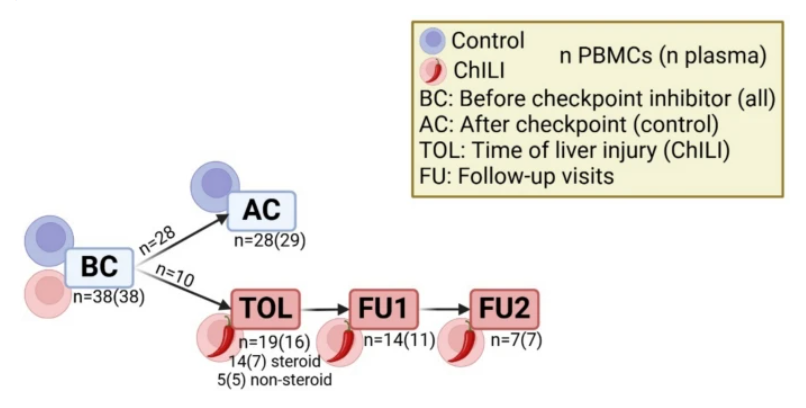

In [7]:
all_samples = list(ann.index)

## Import from S3

In [ ]:
expr = load_expressions_from_s3(
    samples=all_samples, output_path="../data/expression_GSE287540.csv"
)

## ## Alternative: Use preloaded "expression_GSE287540.csv"

In [8]:
expressions = pd.read_csv("../data/expression_GSE287540.csv", index_col=0)
filtered_ann = ann

In [9]:
with open("../data/genes_v2.txt", "r") as f:
    genes_in_expression = [line.rstrip("\n") for line in f]

existing_genes = set(genes_in_expression) & set(expressions.index)

print(len(existing_genes))

18792


In [10]:
normalized_expressions = renormalize_tpm(expressions, existing_genes)
log_normalized_expressions = np.log2(normalized_expressions + 1)

In [11]:
expr = log_normalized_expressions
ann = filtered_ann

common_samples = list(set(expr.columns) & set(ann.index))

expr_filtered = expr[common_samples]
datasets = ann.loc[common_samples, ["Dataset", "Diagnosis", "Sample_type"]]

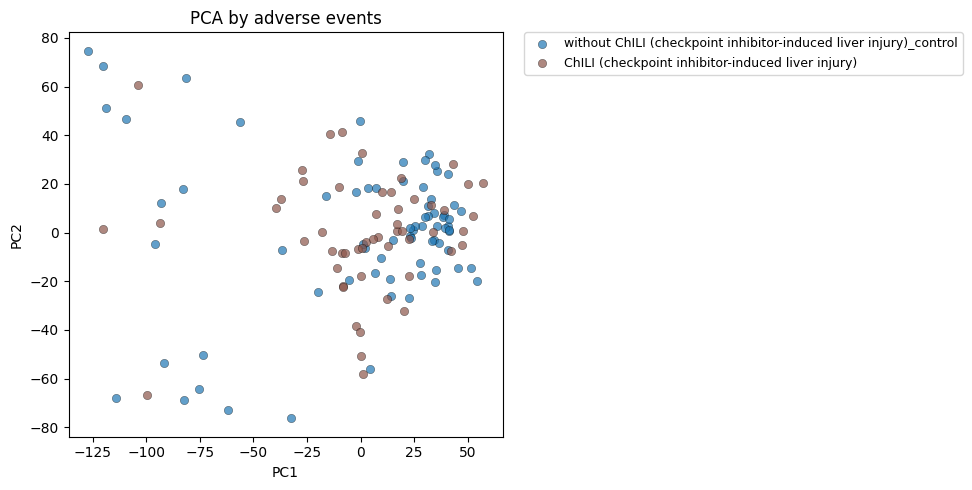

In [12]:
pca_all = compute_pca_all(expr, ann)
plot_pca(pca_all, title="PCA by adverse events", groupby="Adverse_event")

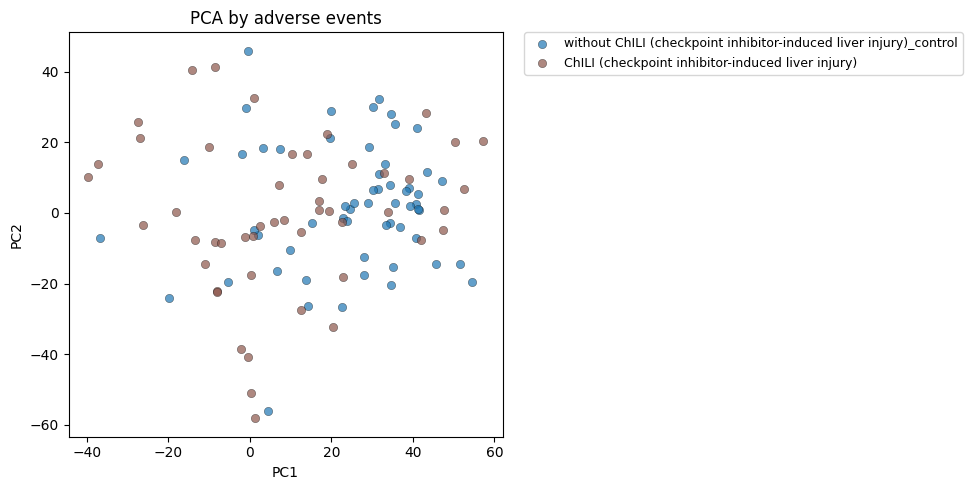

In [13]:
pca_df_filtered = pca_all[
    (pca_all["PC1"].between(-50, 100)) & (pca_all["PC2"].between(-60, 60))
].copy()

plot_pca(pca_df_filtered, title="PCA by adverse events", groupby="Adverse_event")

In [14]:
expr = expr_filtered[pca_df_filtered.index]
common_samples = expr.columns.intersection(ann.index)
expr = expr[common_samples]

# Signatures expressions GSE28754

In [15]:
gene_sets = {
    "Neutrophil_cytotoxity": [
        "RNASE3",
        "MMP8",
        "BPI",
        "OLFM4",
        "MPO",
        "CAMP",
        "CRISP3",
        "DEFA4",
        "CEACAM8",
        "PRTN3",
        "ELANE",
        "LCN2",
        "LTF",
        "CTSG",
        "COL17A1",
        "RETN",
        "HTRA3",
        "DEFA1",
        "CHIT1",
        "CEACAM6",
        "AZU1",
        "DEFA3",
    ],
    "Complement": ["C1QA", "C1QB", "C1QC"],
    "Myeloid_Effector_Program": [
        "KIF13A",
        "ARG1",
        "P2RY13",
        "CKLF",
        "BCL6",
        "PFKFB4",
        "PROK2",
        "IL1R2",
        "CXCL1",
        "MCEMP1",
        "HSPA6",
        "GCA",
        "AMICA1",
        "GPR27",
        "OAZ2",
        "PGLYRP1",
        "CEBPB",
        "PDLIM7",
        "ACSL1",
        "ADGRG3",
        "CRISPLD2",
        "TREM1",
        "AQP9",
        "FPR1",
        "LTB4R",
        "FRAT2",
        "ZNF438",
        "TUBA1A",
        "TYROBP",
        "NFIL3",
        "PLIN5",
        "MSRB1",
        "PYGL",
        "FPR2",
        "DGAT2",
        "H3F3A",
        "MANSC1",
        "CD300A",
        "TALDO1",
        "DYNLT1",
        "NUP214",
        "CXCR1",
        "GNG10",
        "SAT1",
        "QPCT",
        "TBXAS1",
        "MNDA",
        "CCNJL",
        "PTAFR",
        "S100A12",
        "PLAUR",
        "RNF19B",
        "DUSP1",
        "FGR",
        "NFE2",
        "SLC22A4",
        "MRVI1",
        "HCK",
        "NCF4",
        "CEACAM3",
        "BST1",
        "ASPRV1",
        "LIMK2",
        "CLIC1",
        "RGS2",
        "TNFAIP6",
        "SLPI",
        "FRAT1",
        "TPD52L2",
        "NCF2",
        "GLT1D1",
        "FAM214B",
        "MARC1",
        "RNF149",
        "ALOX5AP",
        "MMP25",
        "SRGN",
        "FFAR2",
        "GLIPR2",
        "C19orf38",
        "BASP1",
        "RTN3",
        "IL10RB",
        "CSF3R",
        "CLEC4D",
        "BMX",
        "PHC2",
        "LILRA2",
        "NINJ1",
        "SLC25A44",
        "HSPA1A",
        "KREMEN1",
        "CKAP4",
        "ALPL",
        "CLEC4E",
        "C5AR1",
        "NADK",
        "LRG1",
        "DNTTIP1",
        "LY96",
        "CA4",
        "IFITM2",
        "HCAR2",
        "S100A8",
        "CDKN2D",
        "RHOG",
        "SIGLEC5",
        "SECTM1",
        "S100A9",
        "LRRC25",
        "BCL2A1",
        "ADM",
        "ANXA3",
        "ALOX5",
        "APOBEC3A",
        "PLEKHO2",
        "FTH1",
        "MMP9",
        "HCAR3",
        "PILRA",
        "TSEN34",
        "IFNGR2",
        "APMAP",
        "ARL11",
        "NPL",
        "PPP1R3B",
        "IL1RN",
        "SPI1",
        "SERPINA1",
        "PADI4",
        "PADI2",
        "ARRB2",
        "IL1B",
        "MGAM",
        "NFAM1",
        "CYSTM1",
        "DOK3",
        "NRBF2",
        "SIRPA",
        "HLX",
    ],
    "CXCL1/CXCL8": ["CXCL1", "CXCL8", "H3F3A", "MAP3K7CL", "RGS2", "RNF11"],
    "Acute_Innate_Inflammation": [
        "AGTRAP",
        "C19orf38",
        "CD14",
        "LILRA5",
        "MCEMP1",
        "QSOX1",
        "RAB32",
        "RBP7",
        "S100A12",
        "S100A6",
        "S100A8",
        "S100A9",
        "TYROBP",
    ],
    "IFN-Driven_Myeloid_Inflammation": [
        "IL1B",
        "TRIM21",
        "SECTM1",
        "APOBEC3A",
        "ANKRD22",
        "PARP9",
        "ZNF438",
        "TNFSF10",
        "TNFAIP6",
        "S100A8",
        "SERPING1",
        "CASP1",
        "BCL2A1",
        "IFIT1",
        "CARD16",
        "NMI",
        "TRAFD1",
        "ADM",
        "BATF2",
        "LIPM",
        "DHRS9",
        "IFIT2",
        "FCGR1A",
        "FCGR1B",
        "FFAR2",
        "SQRDL",
        "AIM2",
        "CLIC1",
        "IFIT3",
        "DYNLT1",
        "IL1RN",
    ],
}

## Running ssgsea

In [ ]:
ss = gp.ssgsea(
    data=expr,
    gene_sets=gene_sets,
    sample_norm_method="rank",
    outdir=None,
    permutation_num=0,
    threads=1,
)

ssgsea_scores = ss.res2d
ssgsea_scores = ssgsea_scores.pivot_table(index="Term", columns="Name", values="ES")
ssgsea_scores.columns.name = None
ssgsea_scores.index.name = None
ssgsea_scores = ssgsea_scores.apply(pd.to_numeric, errors="coerce")
ssgsea_scores.to_csv("../data/ssgsea_run_GSE287540.csv")

## Alternative: Use preloaded "ssgsea_GSE287540.csv

In [16]:
ssgsea_scores = pd.read_csv("../data/ssgsea_GSE287540.csv", index_col=[0])

In [19]:
ssgsea_scores

,SRX27409236,SRX27409177,SRX27409205,SRX27409188,SRX27409206,SRX27409185,SRX27409162,SRX27409130,SRX27409161,SRX27409181,...,SRX27409241,SRX27409234,SRX27409128,SRX27409169,SRX27409171,SRX27409163,SRX27409136,SRX27409123,SRX27409189,SRX27409195
Neutrophil_cytotoxity,1856.897961,1983.865340,1466.280851,-7.985777,977.611727,2958.874429,5280.297565,-1886.497948,4739.503904,2607.405119,...,640.057579,1842.539460,5222.522436,-691.491104,274.266970,4397.152499,1820.213697,-127.384801,4372.229000,7118.193665
Complement,-2379.374263,-677.523008,-227.269324,904.390977,-428.198912,-5288.010857,-1162.143165,-5645.288227,-5798.092288,-2570.772718,...,-6091.139071,-500.771794,-612.113376,-4036.293147,-6397.854702,123.590998,-1916.738071,-6033.129810,-744.704553,-1387.742437
Myeloid_Effector_Program,7219.579201,7310.197941,7363.950157,7554.830726,7221.880682,6609.150070,7044.390355,6114.772295,6538.409426,6999.019684,...,7094.140669,6774.719801,7171.425167,6610.041575,7767.814408,7463.365360,6335.412548,6984.010943,7346.794127,7217.841976
CXCL1/CXCL8,4688.207436,3933.856748,6312.623551,5947.409337,5799.791971,3701.030958,5647.186945,4287.802624,4613.071588,6362.313189,...,4518.970858,4483.652765,5061.006041,4876.235203,5098.737187,6876.588532,3834.326156,5570.061598,5890.090511,5983.270696
Acute_Innate_Inflammation,7058.540835,7232.750888,7593.653643,7132.953164,7411.668177,7038.621564,7528.062195,6626.443878,6549.967268,7000.408759,...,6949.161725,7396.422379,7437.766924,6967.585714,8022.553688,7484.814813,5726.058301,7223.760628,7041.744897,7605.763388
IFN-Driven_Myeloid_Inflammation,6551.287969,5989.254859,6657.732641,6889.879899,6370.810083,7247.518482,5708.245111,5321.245312,5830.329768,6383.084815,...,6309.986827,6596.168497,7574.908934,5901.339362,7173.190320,7809.398737,7059.076953,5761.795459,7804.683074,6311.680981


# ChiLi dynamics

In [17]:
expr = ssgsea_scores

time_order = ["Before_therapy", "TOL", "FU1", "FU2"]

common_samples = expr.columns.intersection(ann.index)
expr = expr[common_samples]
ann = ann.loc[common_samples]

ann["Adverse_event"] = ann["Adverse_event"].astype(str).str.strip()
ann["ChILI_status"] = None
ann.loc[
    ann["Adverse_event"].str.contains("without ChILI", case=False, na=False),
    "ChILI_status",
] = "No ChILI"
ann.loc[
    ann["Adverse_event"].str.contains("ChILI", case=False, na=False)
    & ann["ChILI_status"].isna(),
    "ChILI_status",
] = "ChILI"

filtered_ann = ann[
    ann["Material_sampling_time"].isin(time_order)
    & (ann["ChILI_status"] == "ChILI")
    & ann["Donor_id"].notna()
].copy()
filtered_ann["timepoint"] = pd.Categorical(
    filtered_ann["Material_sampling_time"], categories=time_order, ordered=True
)

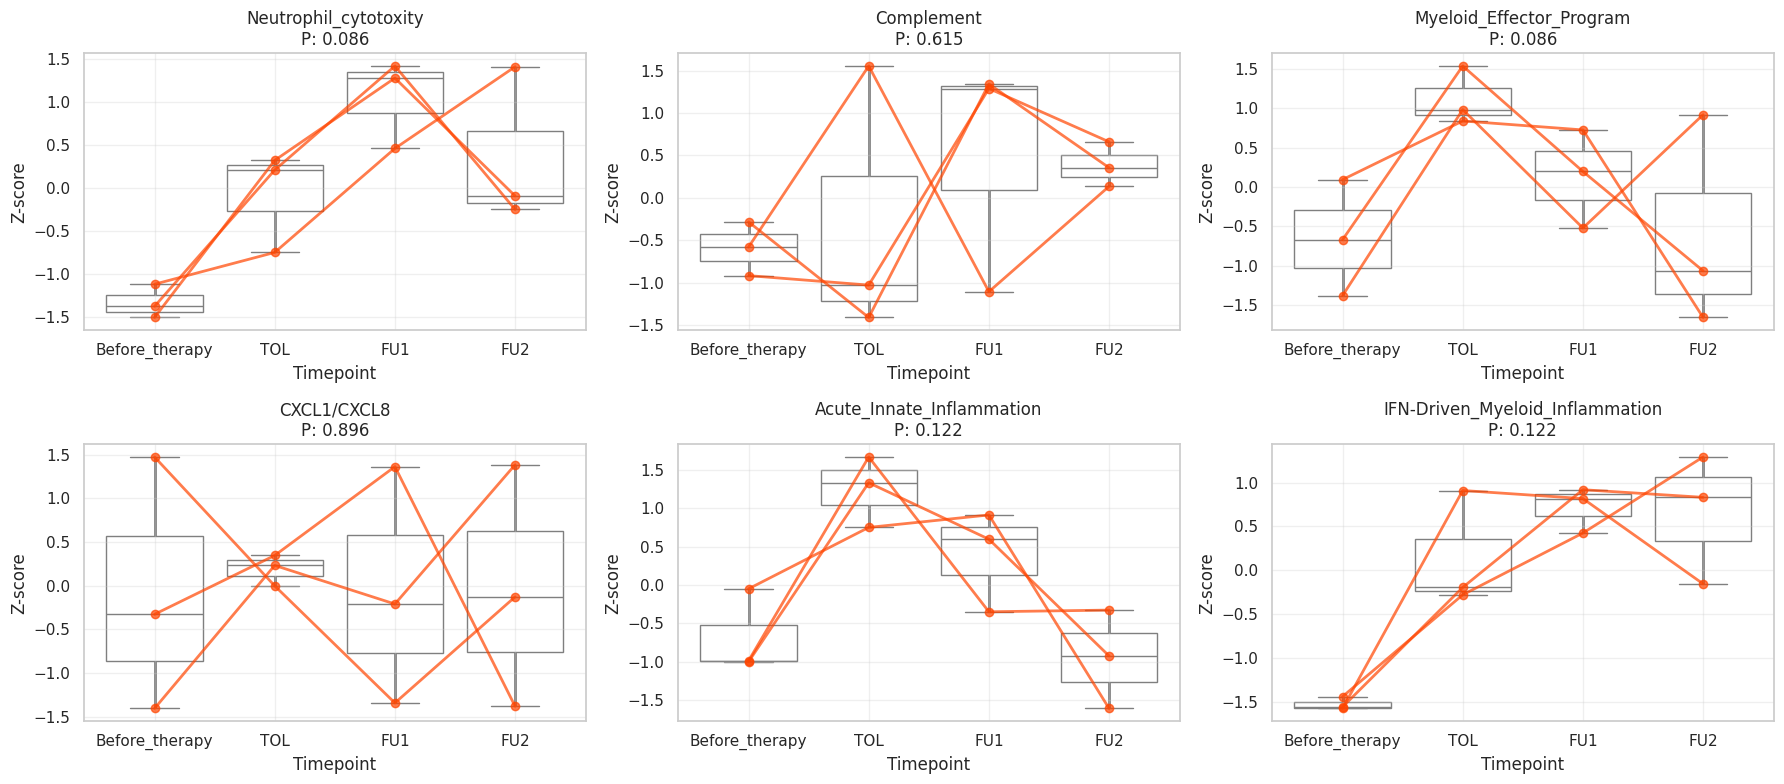

In [18]:
valid_signatures = []
plot_data = []

for signature in expr.index:
    df = filtered_ann.copy()
    df["Signature"] = expr.loc[signature].reindex(df.index)

    df = df[df["Signature"].notna()]
    pivot_df = df.pivot(index="Donor_id", columns="timepoint", values="Signature")
    pivot_df = pivot_df.dropna(subset=["Before_therapy"])

    if pivot_df.shape[0] < 2:
        continue

    pivot_df_z = pivot_df.apply(zscore, axis=1)
    df_z = pivot_df_z.reset_index().melt(
        id_vars="Donor_id", var_name="timepoint", value_name="Signature_zscore"
    )
    df_z["timepoint"] = pd.Categorical(
        df_z["timepoint"], categories=time_order, ordered=True
    )

    valid_signatures.append(signature)
    plot_data.append(df_z)

plot_signature_dynamic(
    valid_signatures=valid_signatures,
    plot_data=plot_data,
    time_order=["Before_therapy", "TOL", "FU1", "FU2"],
    output_path="../images/validation/chili_dynamic.png",
)    


# Healthy vs ChiLi

In [ ]:
subset = ann.copy()
subset["Group"] = None
subset.loc[
    (subset["Adverse_event"].str.contains("ChILI"))
    & (subset["Material_sampling_time"].str.upper() == "TOL"),
    "Group",
] = "ChILI+ (TOL)"
subset.loc[
    subset["Adverse_event"].str.contains("without ChILI", case=False), "Group"
] = "No ChILI"

subset = subset.dropna(subset=["Group"])
common_samples = expr.columns.intersection(subset.index)
expr_sub = expr[common_samples]
grouping = subset.loc[common_samples, "Group"]

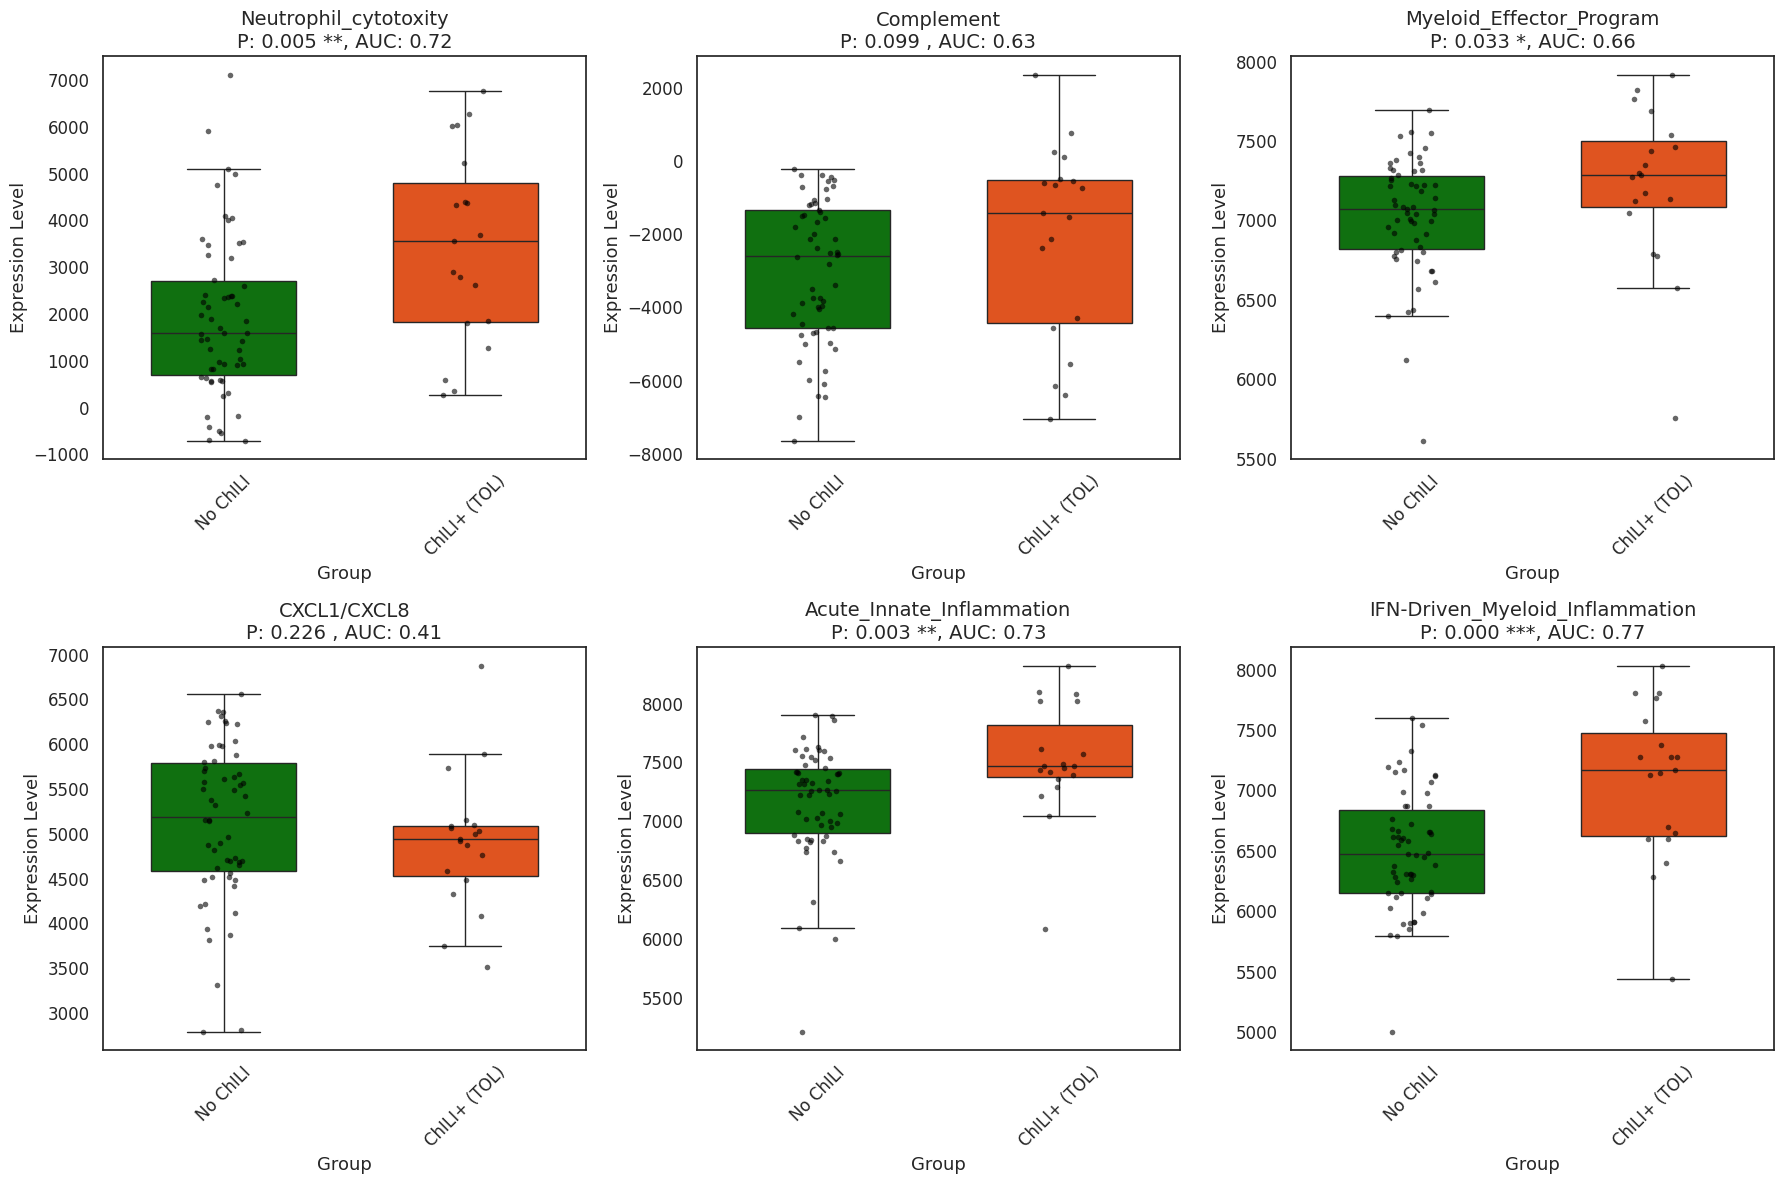

In [ ]:
plot_boxplot(
    expr=expr_sub,
    grouping=grouping,
    output_image="../images/validation/chili_boxplots.png",
)

## Baseline

In [ ]:
subset = ann.copy()
subset["Group"] = None

subset.loc[
    subset["Adverse_event"].str.contains("without ChILI", case=False, na=False)
    & (subset["Material_sampling_time"] == "Before_therapy"),
    "Group",
] = "No ChILI (baseline)"

subset.loc[
    subset["Adverse_event"].str.contains("ChILI", case=False, na=False)
    & (subset["Material_sampling_time"] == "Before_therapy")
    & subset["Group"].isna(),
    "Group",
] = "ChILI (baseline)"


subset = subset.dropna(subset=["Group"])
common_samples = expr.columns.intersection(subset.index)
expr_sub = expr[common_samples]
grouping = subset.loc[common_samples, "Group"]

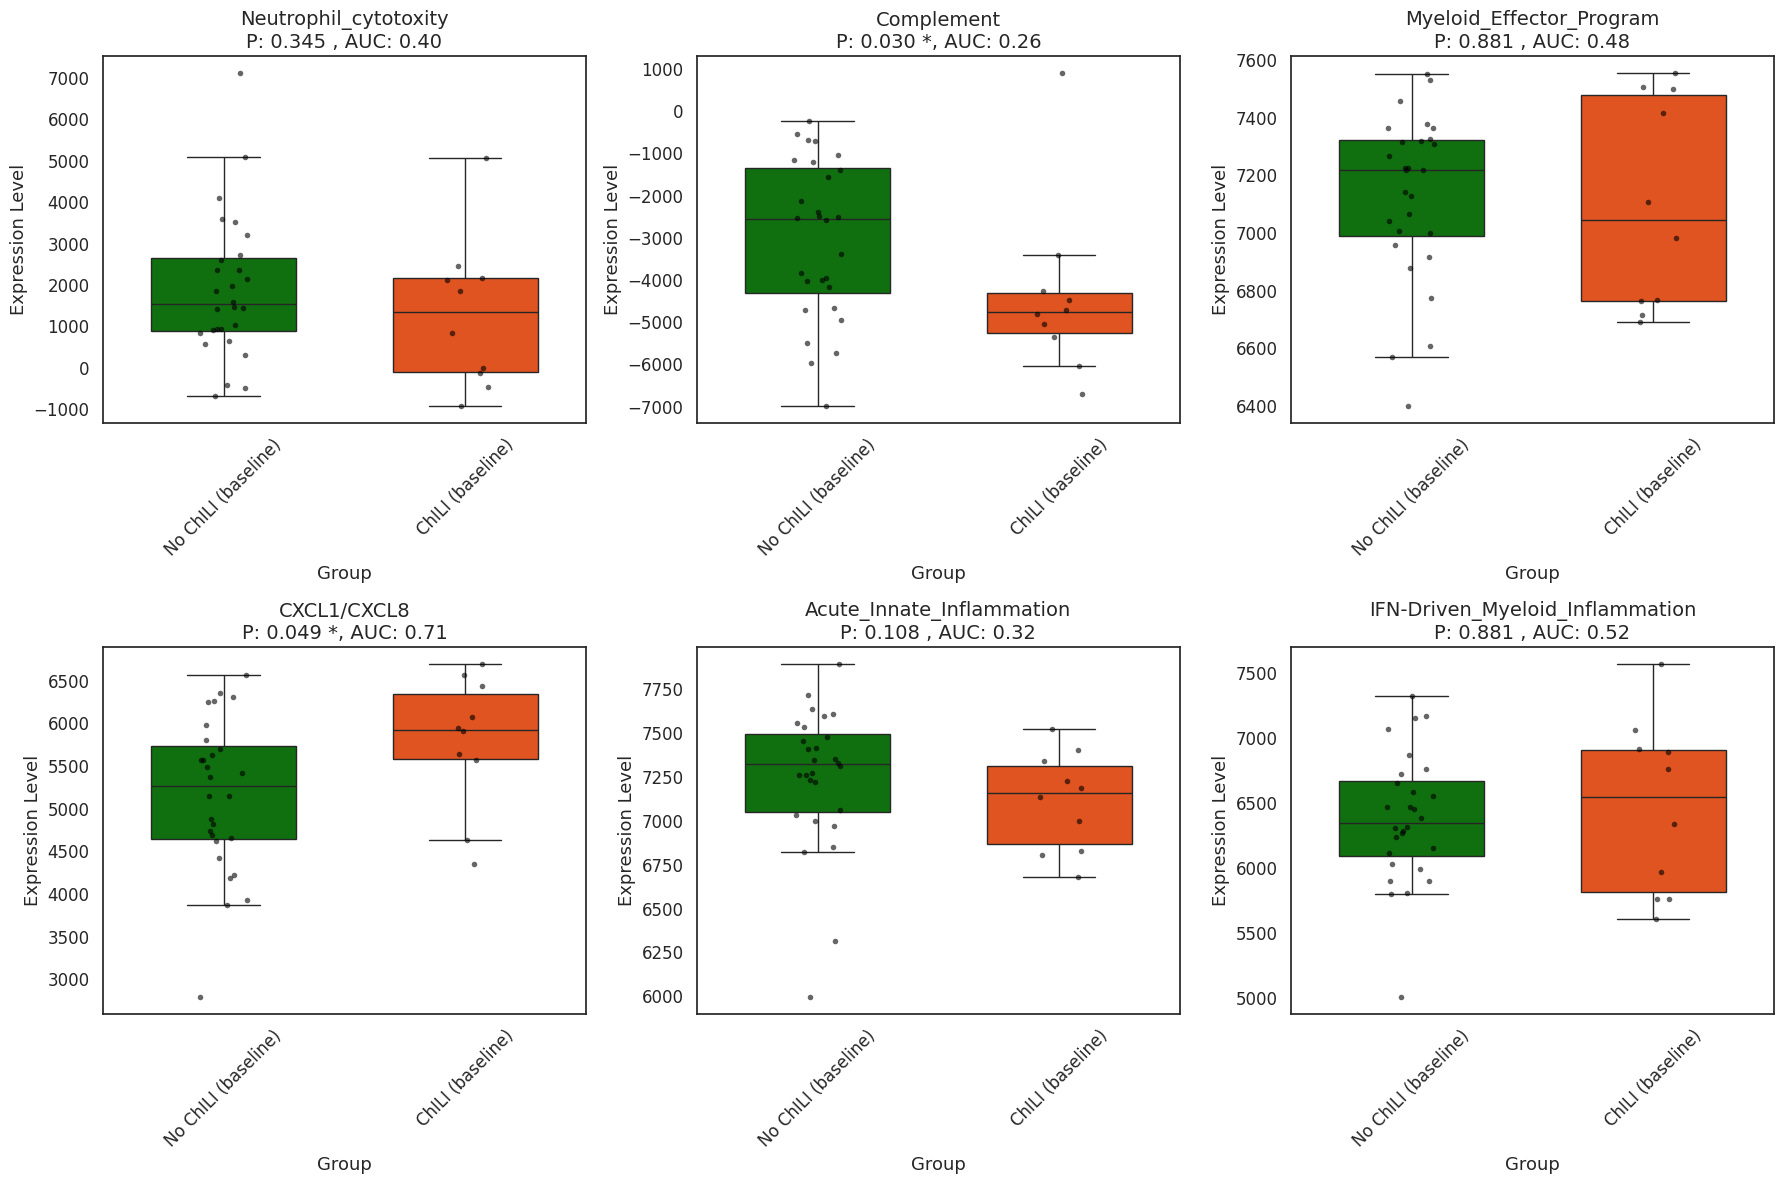

In [ ]:
plot_boxplot(
    expr=expr_sub,
    grouping=grouping,
    output_image="../images/validation/chili_boxplots_baseline.png",
)

## Deconvolution

In [ ]:
df = pd.read_csv("../data/cibersort_results.csv", index_col=0)

df.head()

,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),T cells gamma delta,...,Macrophages M2,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils,P-value,Correlation,RMSE
SRX27409250,0.051359,0.000000,0.040127,0.128941,0.094340,0.039212,0.048585,0.0,0,0.000000,...,0.000000,0.000000,0.021287,0.000000,0.005052,0.0,0.428655,9999,0.660390,0.751195
SRX27409249,0.068046,0.000000,0.015065,0.255254,0.000000,0.010585,0.000000,0.0,0,0.014717,...,0.000000,0.000000,0.008636,0.000000,0.000000,0.0,0.368976,9999,0.594347,0.805998
SRX27409248,0.000000,0.034972,0.022376,0.081662,0.114493,0.000000,0.050861,0.0,0,0.000000,...,0.000000,0.005615,0.017880,0.000389,0.000000,0.0,0.483265,9999,0.696274,0.718230
SRX27409247,0.000000,0.018604,0.020874,0.034849,0.108321,0.052911,0.013279,0.0,0,0.000000,...,0.029934,0.001039,0.016539,0.006411,0.000000,0.0,0.609206,9999,0.760091,0.653473
SRX27409246,0.000000,0.010788,0.014911,0.043967,0.074079,0.018761,0.038106,0.0,0,0.000000,...,0.000000,0.000000,0.018901,0.028133,0.000000,0.0,0.566549,9999,0.766564,0.643981


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128 entries, SRX27409250 to SRX27409123
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   B cells naive                 128 non-null    float64
 1   B cells memory                128 non-null    float64
 2   Plasma cells                  128 non-null    float64
 3   T cells CD8                   128 non-null    float64
 4   T cells CD4 naive             128 non-null    float64
 5   T cells CD4 memory resting    128 non-null    float64
 6   T cells CD4 memory activated  128 non-null    float64
 7   T cells follicular helper     128 non-null    float64
 8   T cells regulatory (Tregs)    128 non-null    int64  
 9   T cells gamma delta           128 non-null    float64
 10  NK cells resting              128 non-null    float64
 11  NK cells activated            128 non-null    float64
 12  Monocytes                     128 non-null    float

In [ ]:
cell_fractions = df.drop(
    columns=["P-value", "Correlation", "RMSE"], errors="ignore"
).copy()

monocyte_related = ["Macrophages M0", "Macrophages M1", "Macrophages M2", "Monocytes"]

cell_fractions["Monocytes"] = cell_fractions[monocyte_related].sum(axis=1)
cell_fractions = cell_fractions.drop(columns=monocyte_related, errors="ignore")

sum_per_row = cell_fractions.sum(axis=1)
cell_fractions = cell_fractions.div(sum_per_row, axis=0)

/home/les2612/sigantures_project/sigantures_project/code/scripts/graphics.py:164: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_name, group_df in df_all.groupby(group_col, sort=False):


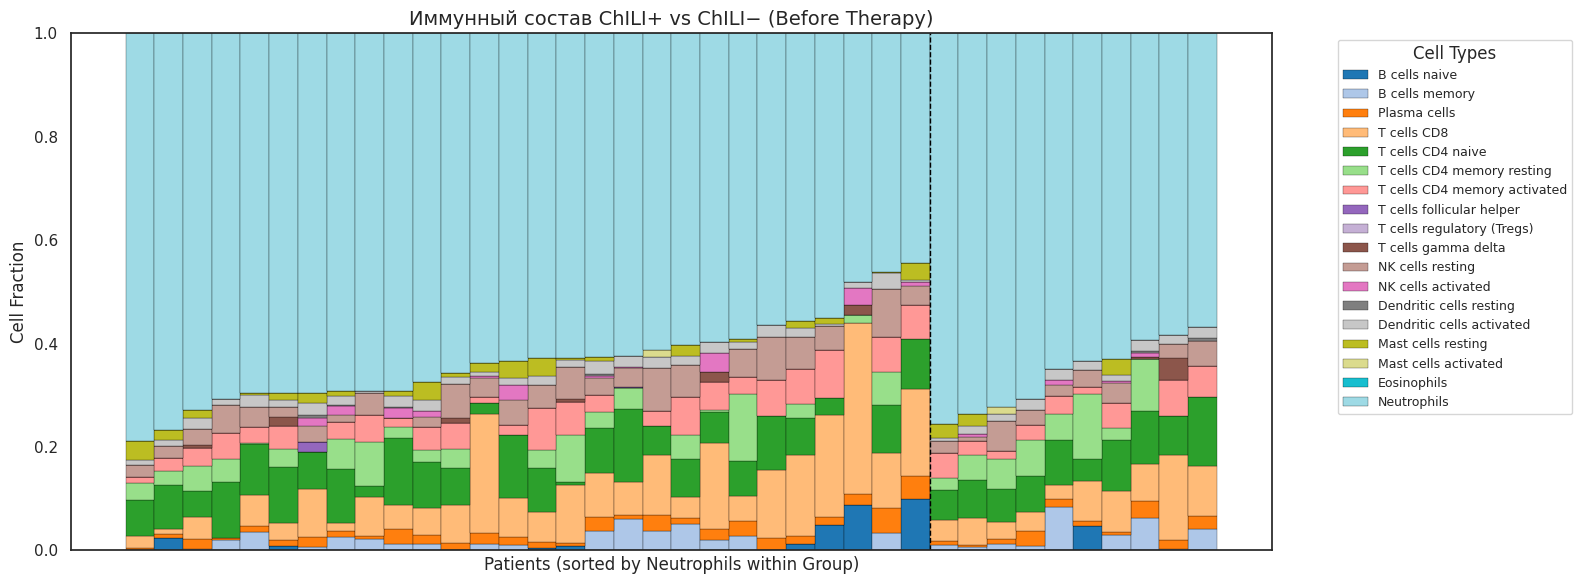

In [ ]:
ann = ann.copy()

ann["Group"] = None

ann.loc[
    ann["Adverse_event"].str.contains("without ChILI", case=False, na=False)
    & (ann["Material_sampling_time"] == "Before_therapy"),
    "Group",
] = "ChILI−"

ann.loc[
    ann["Adverse_event"].str.contains("ChILI", case=False, na=False)
    & (~ann["Adverse_event"].str.contains("without", case=False, na=False))
    & (ann["Material_sampling_time"] == "Before_therapy")
    & ann["Group"].isna(),
    "Group",
] = "ChILI+"

plot_cibersort_stacked(
    fractions=cell_fractions,
    annotation=ann,
    group_col="Group",
    group_order=["ChILI−", "ChILI+"],
    sort_by="Neutrophils",
    title="ChILI+ vs ChILI− (Before Therapy)",
    filename="cyberplot.png",
)

/home/les2612/sigantures_project/sigantures_project/code/scripts/graphics.py:164: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_name, group_df in df_all.groupby(group_col, sort=False):


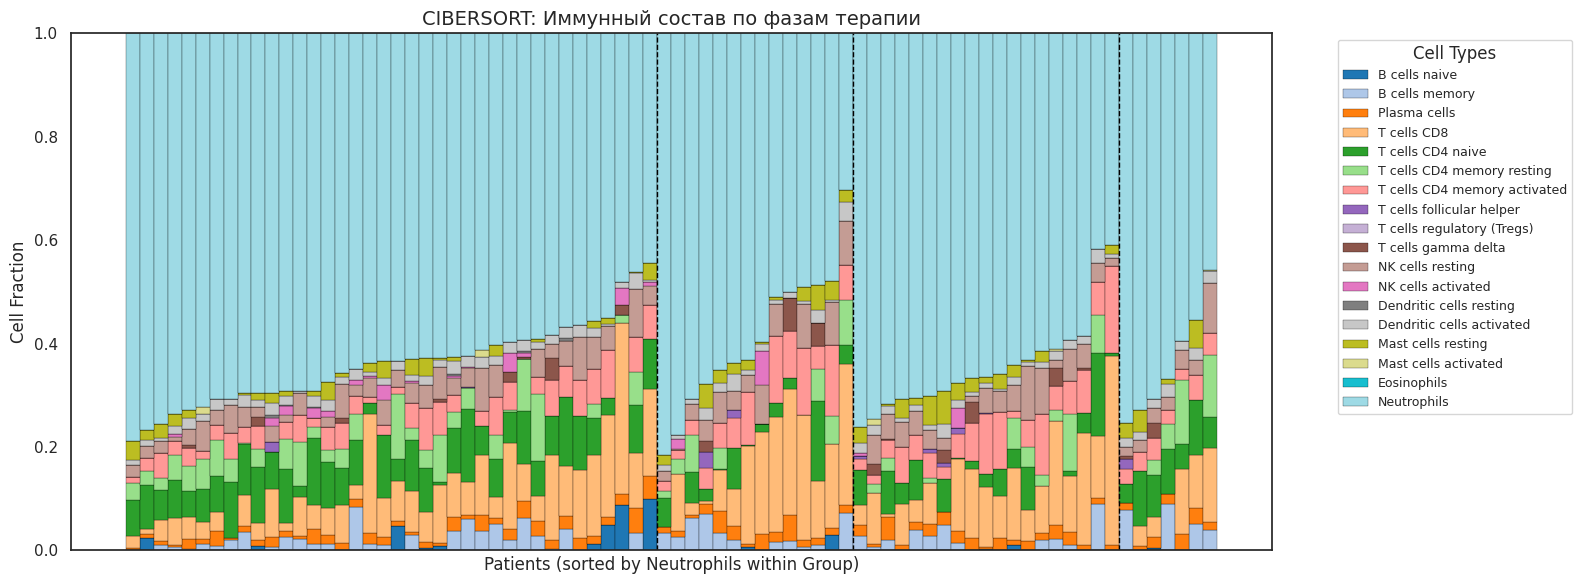

In [ ]:
ann = ann.copy()
ann.index = ann.index.astype(str).str.strip()
ann["Group"] = ann["Material_sampling_time"].astype(str).str.strip()

time_order = ["Before_therapy", "TOL", "FU1", "FU2"]
ann = ann[ann["Group"].isin(time_order)]
ann["Group"] = pd.Categorical(ann["Group"], categories=time_order, ordered=True)

cell_fractions.index = cell_fractions.index.astype(str).str.strip()

plot_cibersort_stacked(
    fractions=cell_fractions,
    annotation=ann,
    group_col="Group",
    group_order=time_order,
    sort_by="Neutrophils",
    title="CIBERSORT: Иммунный состав по фазам терапии",
    filename="cibersort_by_timepoint.png",
)

In [ ]:

ann = ann.copy()
ann["Adverse_event"] = ann["Adverse_event"].astype(str).str.strip()
ann["Group"] = None

ann.loc[
    ann["Adverse_event"].str.contains("without ChILI", case=False, na=False)
    & (ann["Material_sampling_time"] == "Before_therapy"),
    "Group",
] = "No ChILI"

ann.loc[
    ann["Adverse_event"].str.contains("ChILI", case=False, na=False)
    & (~ann["Adverse_event"].str.contains("without", case=False, na=False))
    & (ann["Material_sampling_time"] == "Before_therapy")
    & ann["Group"].isna(),
    "Group",
] = "ChILI"

ann = ann.dropna(subset=["Group"])

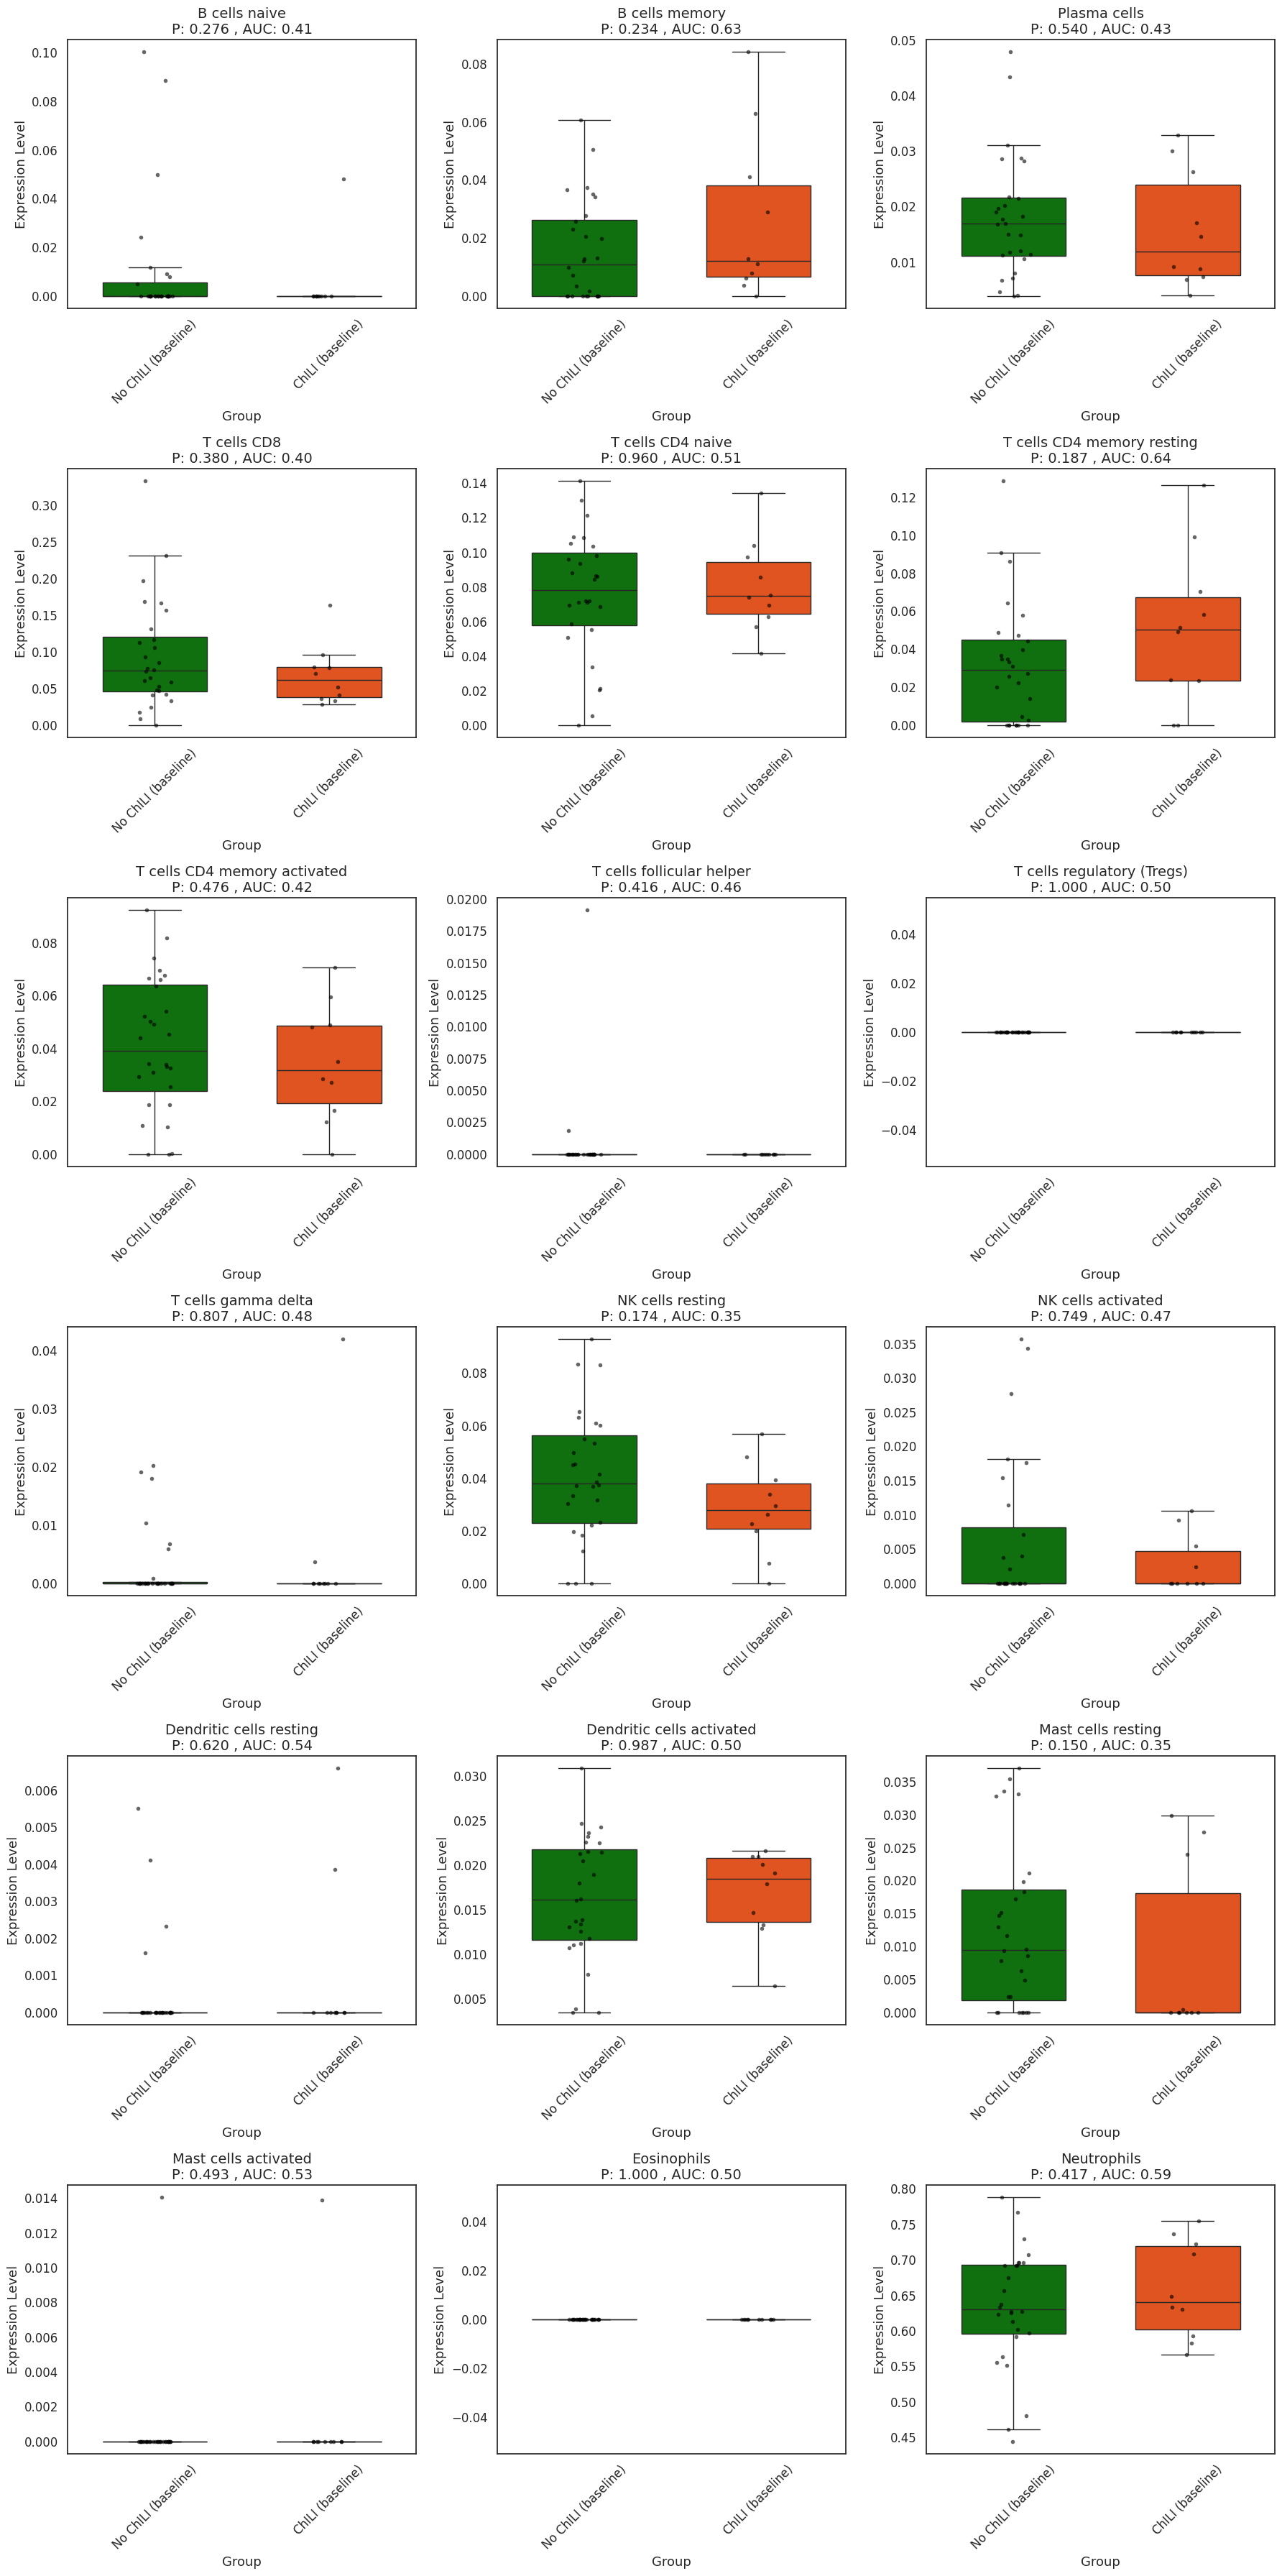

In [ ]:
subset = ann.copy()
subset["Group"] = None

subset.loc[
    subset["Adverse_event"].str.contains("without ChILI", case=False, na=False)
    & (subset["Material_sampling_time"] == "Before_therapy"),
    "Group",
] = "No ChILI (baseline)"

subset.loc[
    subset["Adverse_event"].str.contains("ChILI", case=False, na=False)
    & (subset["Material_sampling_time"] == "Before_therapy")
    & subset["Group"].isna(),
    "Group",
] = "ChILI (baseline)"

subset = subset.dropna(subset=["Group"])

cell_fractions.index = cell_fractions.index.astype(str).str.strip()
subset.index = subset.index.astype(str).str.strip()

common_samples = cell_fractions.index.intersection(subset.index)

expr_sub = cell_fractions.loc[common_samples].T
grouping = subset.loc[common_samples, "Group"]

plot_boxplot(expr_sub, grouping, output_image="cibersort_boxplot_baseline.png")

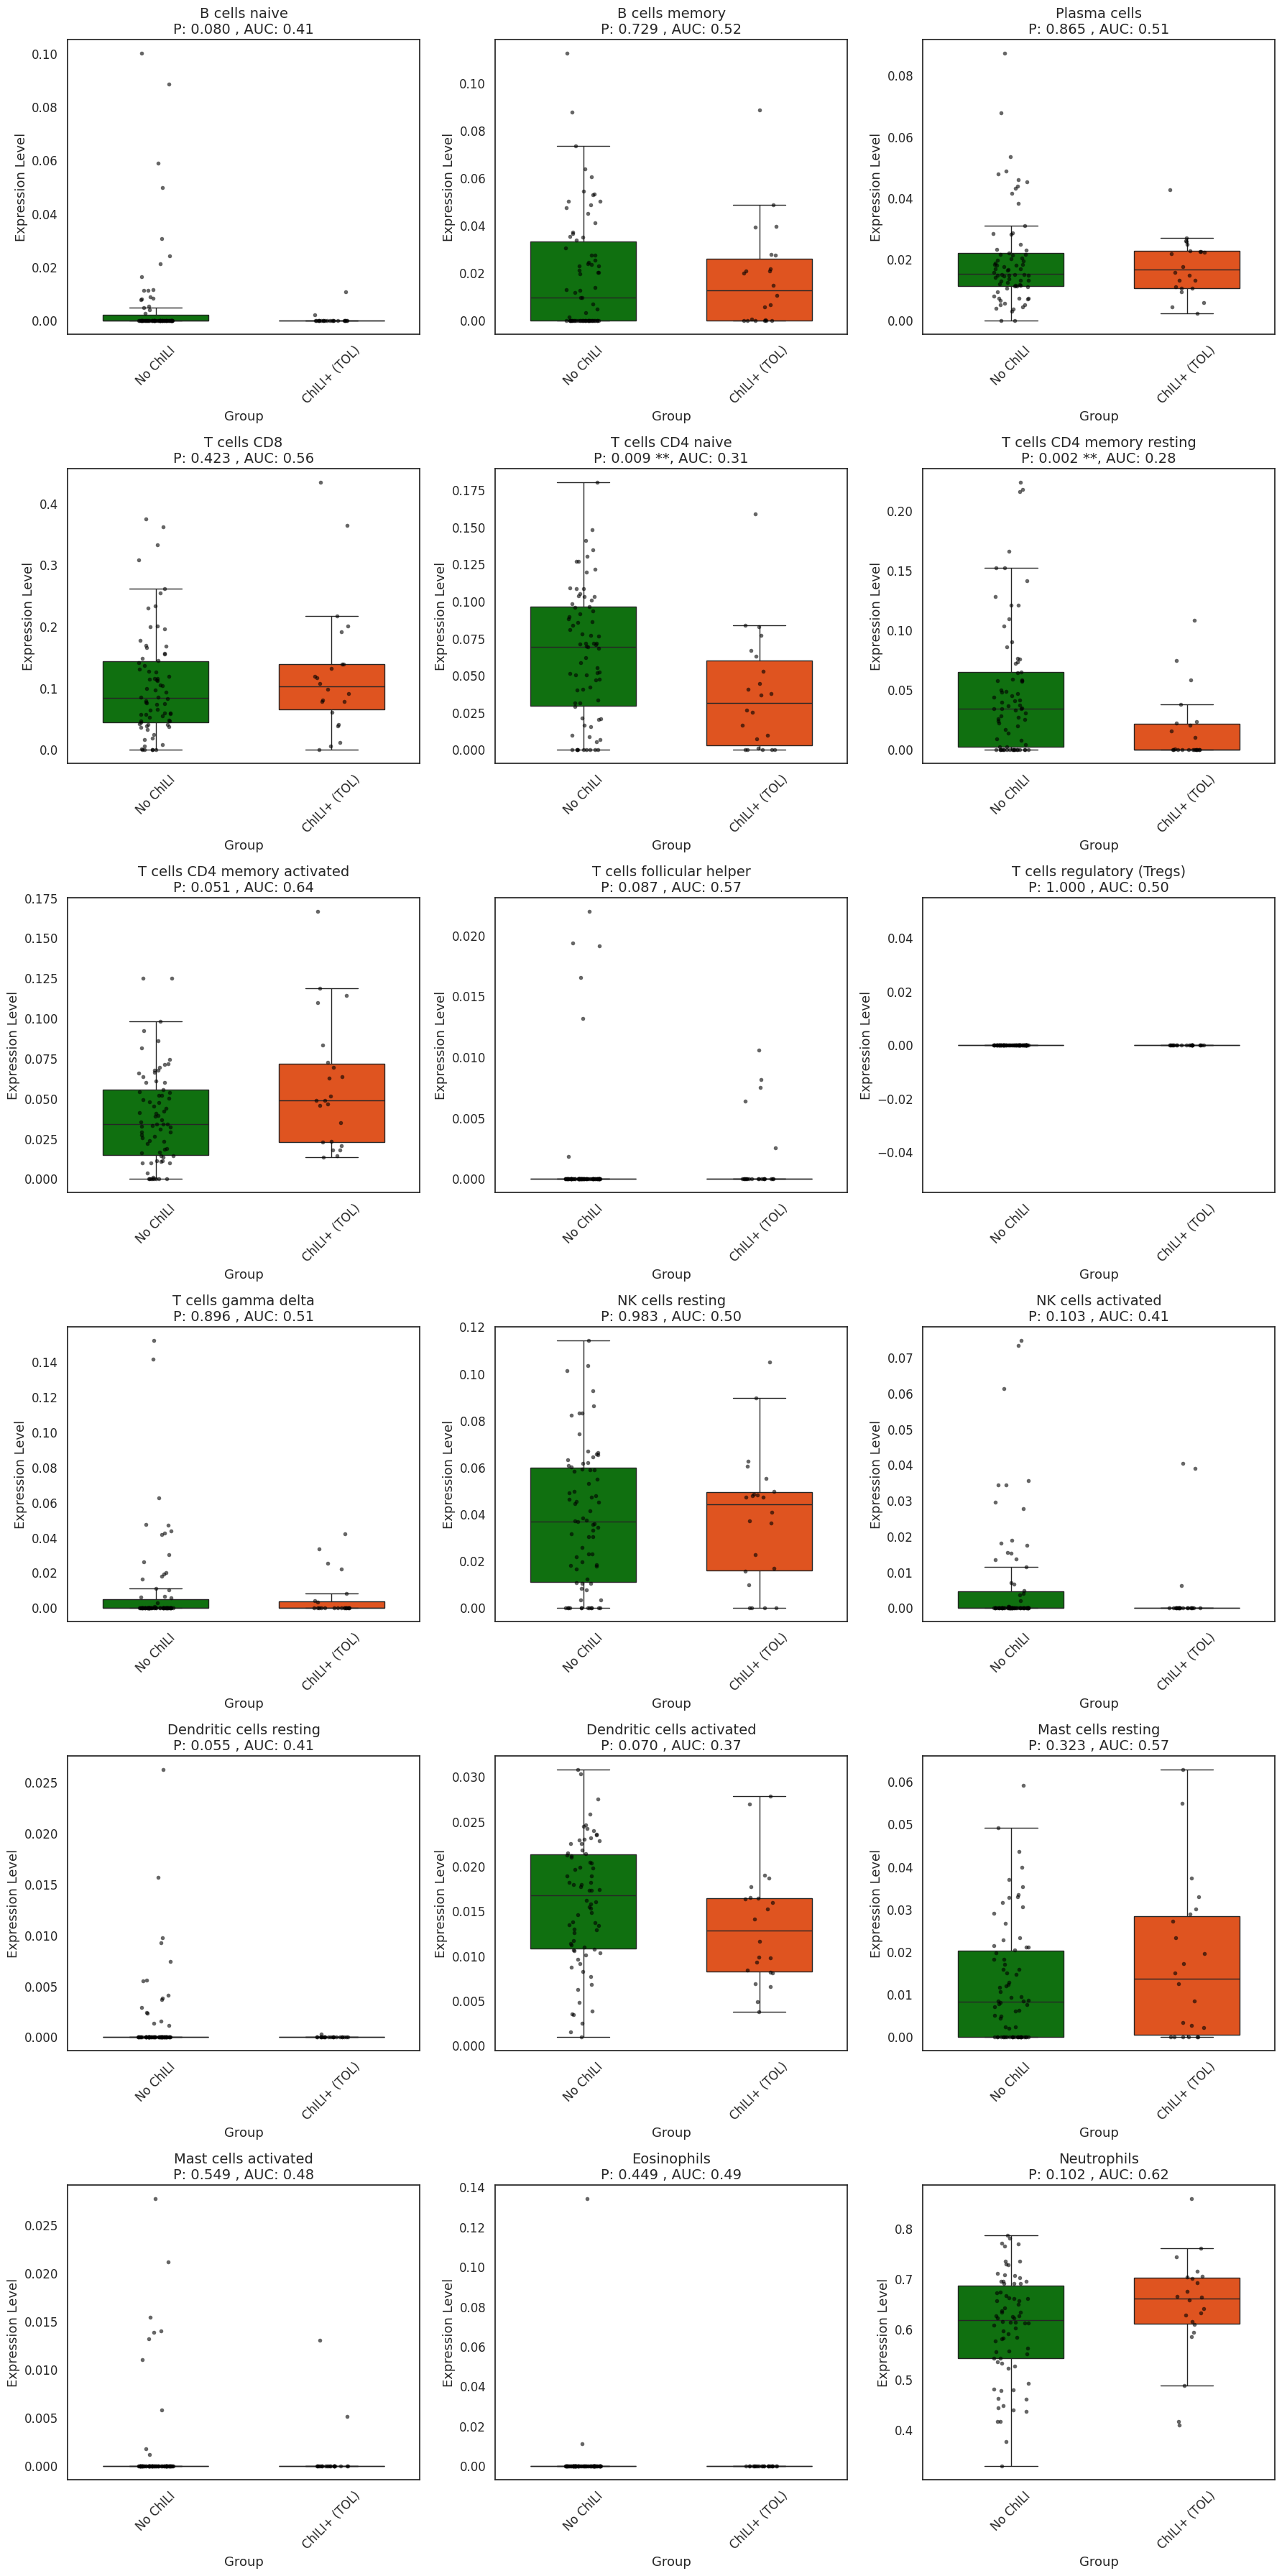

In [ ]:
datasets = ["GSE287540"]
ann = blood_all_annotation[blood_all_annotation["Dataset"].isin(datasets)]
subset = ann.copy()
subset["Group"] = None

subset.loc[
    (subset["Adverse_event"].str.contains("ChILI", case=False))
    & (subset["Material_sampling_time"].str.upper() == "TOL"),
    "Group",
] = "ChILI+ (TOL)"

subset.loc[
    subset["Adverse_event"].str.contains("without ChILI", case=False), "Group"
] = "No ChILI"

subset = subset.dropna(subset=["Group"])

subset.index = subset.index.astype(str).str.strip()
cell_fractions.index = cell_fractions.index.astype(str).str.strip()

common_samples = cell_fractions.index.intersection(subset.index)
expr_sub = cell_fractions.loc[common_samples].T
grouping = subset.loc[common_samples, "Group"]

plot_boxplot(
    expr=expr_sub,
    grouping=grouping,
    output_image="cybersort_tol_vs_nochili_boxplot.png",
)